Since my last post, I have been experimenting with the [noise package](https://github.com/caseman/noise) from Casey Duncan. This package is the easy solution for generating Perlin noise that I had hoped for. It seems simple and fast, though one downside at least to me is that it doesn't play so nicely with numpy arrays. This is not a big deal, though. It was probably not developed for scientists but rather for game design and/or computer graphics.

So, let's use this library to continue exploring the question of why correlated noise often makes for a better model of the real world.

In [1]:
%pylab inline
import seaborn as sns
from matplotlib import animation
from noise import pnoise1, pnoise3
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.dpi'] = 120
sns.set_color_codes()

Populating the interactive namespace from numpy and matplotlib


# Generating Perlin noise with the `noise` library

The basic function `pnoise1()` takes a single float argument x. It won't work with numpy arrays. For this reason, I'm generating the noise signal in a `for` loop.

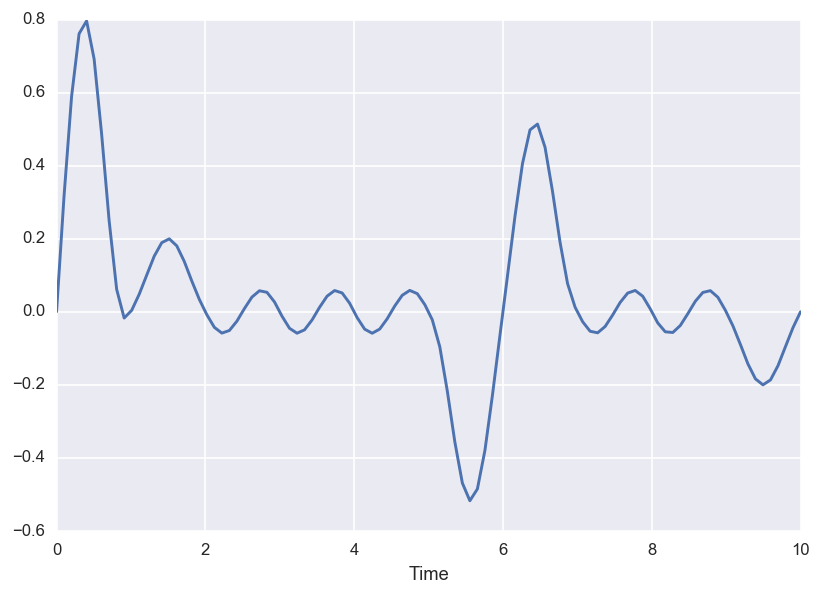

In [3]:
numPoints = 100
time      = np.linspace(0, 10, num = numPoints)

# Generate the signal one element at a time
signal    = np.zeros(numPoints)

for ctr, t in enumerate(time):
    signal[ctr] = pnoise1(t)

plt.plot(time, signal)
plt.xlabel('Time')
plt.show()

The `octaves` and `persistence` parameters determine how much energy is contained at frequencies in each successive octave of the noise's [power spectrum](https://en.wikipedia.org/wiki/Spectral_density#Power_spectral_density). These parameters determine the presence and strength, respectively, of the finer details in the noise signal. Before going into them with more detail, we can vary them and observe the outcome.

Here's the result of varying the number of octaves.

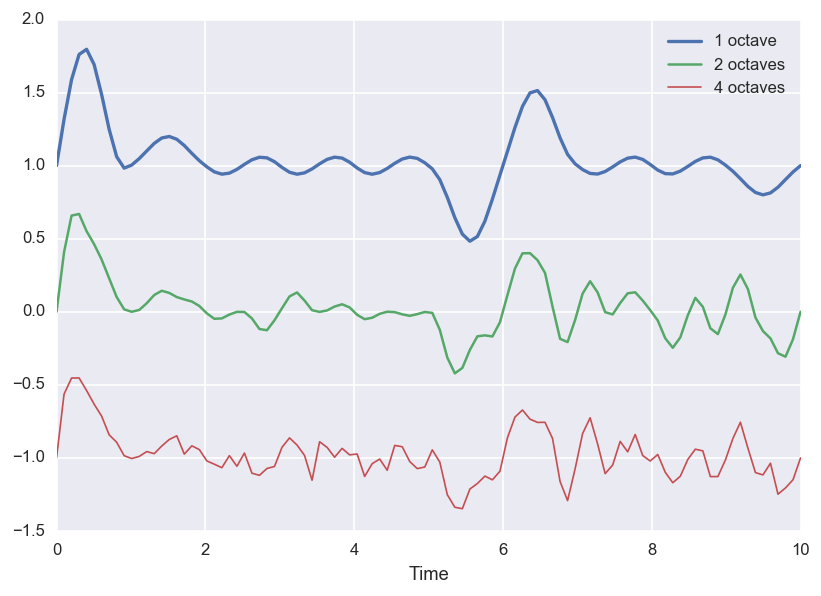

In [4]:
signal2 = np.zeros(numPoints)
signal3 = np.zeros(numPoints)
for ctr, t in enumerate(time):
    signal[ctr]  = pnoise1(t, octaves = 1) + 1
    signal2[ctr] = pnoise1(t, octaves = 2)
    signal3[ctr] = pnoise1(t, octaves = 4) - 1

plt.plot(time, signal,  label = '1 octave',  linewidth = 2)
plt.plot(time, signal2, label = '2 octaves', linewidth = 1.5)
plt.plot(time, signal3, label = '4 octaves', linewidth = 1.0)
plt.xlabel('Time')
plt.legend()
plt.show()

In the above plot, and besides constant offsets to aid in visualization, I added one and three additional octaves to the noise, keeping the persistence fixed. Increasing the octaves makes the curve appear more 'jagged' and noisy on the smaller scales, much like extending the frequency range of the filter applied to the random signal from [my last post](http://kmdouglass.github.io/posts/correlated-noise-and-the-fft.html). Over longer time scales, the curve more or less follows the original one.

Below you can see what happens when we use four octaves but increase the persistence gradually. The amplitude of the spikes at small time scales increases with increasing persistence.

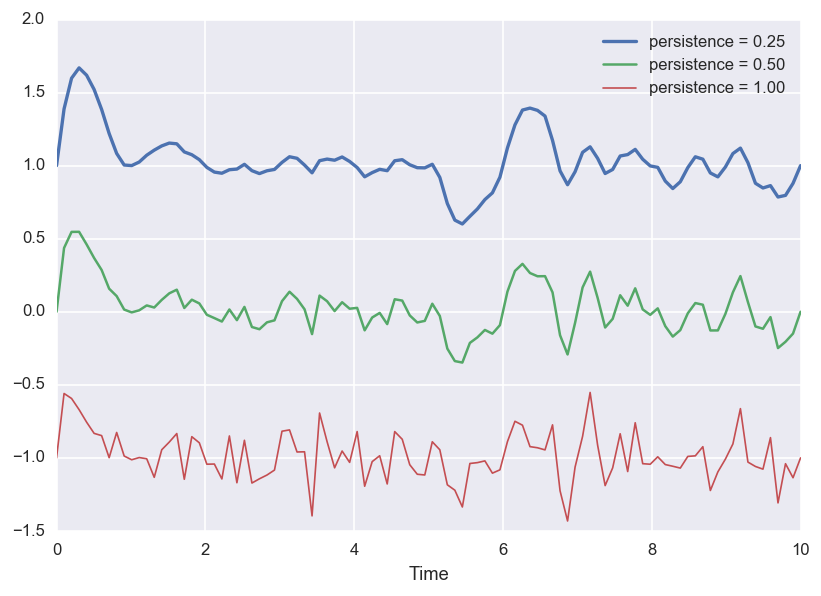

In [5]:
for ctr, t in enumerate(time):
    signal[ctr]  = pnoise1(t, octaves = 4, persistence = 0.25) +1
    signal2[ctr] = pnoise1(t, octaves = 4, persistence = 0.5)
    signal3[ctr] = pnoise1(t, octaves = 4, persistence = 1) - 1

plt.plot(time, signal,  label = 'persistence = 0.25',  linewidth = 2)
plt.plot(time, signal2, label = 'persistence = 0.50', linewidth = 1.5)
plt.plot(time, signal3, label = 'persistence = 1.00', linewidth = 1.0)
plt.xlabel('Time')
plt.legend()
plt.show()

We're now in a good position to summarize a few of the main characteristics about Perlin noise. I'll use the term 'feature' as a loose definition for the hills and valleys seen in the curves.
1. Perlin noise is a random signal that is correlated over short time scales.
2. The number of octaves determines the time/length scales at which features in the signal are present.
3. The persistence determines the amplitude of the features.

The existence of features at smaller-and-smaller scales and how strongly these features decrease in amplitude with scale are the [fractal-like properties](https://en.wikipedia.org/wiki/Fractal#Natural_phenomena_with_fractal_features) of the noise signal. So Perlin noise is essentially a way of generating random fractals on a computer. Unlike the deterministic fractals that we normally think of, these are statistical.

In the final parts of this post, let's see how we can use correlated noise to model realistic motions of particles.

# Random waveforms in time
Because Perlin noise is continuous, we can easily generate a nice-looking, traveling Perlin noise waveform and animate it. To do this, I use `FuncAnimation` from [matplotlib's animation API](http://matplotlib.org/api/animation_api.html). Every time `FuncAnimation` is called, I add a constant to the time array, which shifts the curve to the left. I'm also plotting a small particle undergoing a 1D walk and whose position is equivalent to the waveform value at the left-most side of the axis.

In [6]:
# Generate initial axis for the waveform
numPoints = 1000
time      = np.linspace(0, 10, num = numPoints)
signal    = np.zeros(numPoints)
fig, ax = plt.subplots(nrows = 1, ncols = 1)
line,   = ax.plot([], [])
ax.set_xlim((np.min(time), np.max(time)))
ax.set_ylim((-1, 1))
ax.set_yticklabels([])
ax.set_xlabel('Time')

# Generate initial axis for the particle
divider   = make_axes_locatable(ax)
pax       = divider.append_axes('left', size = '5%', pad = 0.05)
particle, = pax.plot([], [], 'o')
pax.set_xlim((-0.5, 0.5))
pax.set_ylim((-1, 1))
pax.set_xticks([])
pax.grid(False)

# Initialize the figure with an empty, single tuple of line
def init():
    line.set_data([],[])
    particle.set_data([],[])
    return line, particle

# This function is called for each frame of the animation
def animate(frame):
    dt = 0.01 * frame
    for ctr, t in enumerate(time):
        signal[ctr] = pnoise1(t + dt, octaves = 4, persistence = 0.5)
        
    # Update waveform and particle
    line.set_data(time, signal)
    particle.set_data(np.array([0]), signal[0])
    return line, particle

# Create the animation
anim = animation.FuncAnimation(fig,
                               animate,
                               frames = 1000,
                               init_func = init,
                               interval = 20,
                               blit = True)

# Save the animation
myWriter = animation.FFMpegWriter(fps = 30, extra_args=['-vcodec', 'libx264'])
anim.save('traveling_Perlin_wave.mp4', writer = myWriter)
    
plt.close()

<video controls src="../traveling_Perlin_wave.mp4" type="video/mp4" />

Although random, we can see that the particle moves smoothly and continiously. If I were add more octaves or increase the persistence of the walk, the particle would move more erraticly because I would have introduced more high frequency noise like the pink noise example in [my previous post](http://kmdouglass.github.io/posts/correlated-noise-and-the-fft.html).

# Random Perlin and Brownian Walks

Finally, let's compare a random walk created using Perlin noise to one created with [white noise](https://en.wikipedia.org/wiki/White_noise), which is completely uncorrelated. A walk generated with white noise is the same as good ol' Brownian motion. By comparing the two, you should be able to see why Perlin noise often better approximates natural phenomena: things just don't look quite natural when modeled with white noise.

In [7]:
# Initialize the axis and two different walk trajectories
fig, ax = plt.subplots(nrows = 1, ncols = 1)
pWalk, = ax.plot([], [], 'o') # Perlin walk
bWalk, = ax.plot([], [], 'ro') # Brownian walk
ax.set_xlim((-100, 100))
ax.set_ylim((-100, 100))
ax.set_xlabel('x-Position')
ax.set_ylabel('y-Position')
ax.set_aspect('equal')
ax.legend([pWalk, bWalk], ['Perlin walker', 'Brownian walker'])

start, stop, step = 0, 100, 0.01
time = np.arange(start, stop, step)

# Create arrays for the x and y positions of the Perlin walker
px   = np.zeros(len(time))
py   = np.zeros(len(time))
for ctr, t in enumerate(time):
    # offset of 1000 ensures x and y are uncorrelated
    px[ctr] = pnoise1(t,        octaves = 4, persistence = 0.5)
    py[ctr] = pnoise1(t + 1000, octaves = 4, persistence = 0.5)
px = np.cumsum(px)
py = np.cumsum(py)

# The Brownian walker
bx = np.random.randn(len(time))
by = np.random.randn(len(time))
bx = np.cumsum(bx)
by = np.cumsum(by)

def init():
    pWalk.set_data([],[])
    bWalk.set_data([],[])
    return line, particle

# This function is called for each frame of the animation
def animate(frame):
    # Update the walker positions
    pWalk.set_data(px[frame], py[frame])
    bWalk.set_data(bx[frame], by[frame])
    return pWalk, bWalk

# Create the animation
anim = animation.FuncAnimation(fig,
                               animate,
                               frames = 1000,
                               init_func = init,
                               interval = 20,
                               blit = True)

# Save the animation
myWriter = animation.FFMpegWriter(fps = 30, extra_args=['-vcodec', 'libx264'])
anim.save('walkers.mp4', writer = myWriter)

plt.close()

<video controls src="../walkers.mp4" type="video/mp4" />

The Perlin walker is just a calm, casual guy out for a walk, whereas the Brownian walker is your officemate after five cups of coffee.

So there you have it! Perlin noise is an interesting tool for generating correlated noise forms on a computer. It's used in a number of applications in computer graphics, animation, and games to produce realistic-looking patterns.

I only mentioned it briefly, but one of the reasons its patterns look more realistic than white noise forms is that it has fractal properties. In a later post, I'll explore what I mean by this by using the FFT tools and [the pink noise example I generated](http://kmdouglass.github.io/posts/correlated-noise-and-the-fft.html) in my last post.